### For this notebook, you should use the custom version of transformers (see `readme.md` for how to install the environment)

This notebook contains a ready for use code to train CamemBERT-bio + LESA on your own medical dataset. 
It only requires your dataset to be a list of samples: `{'tokens': [`$w_1, w_2, \cdots, w_n$`], 'classes': int list}`

In order to properly break the text into words, use the tools in the utils directory

In [ ]:
import functools
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import CamembertForTokenClassification_label, CamembertForMaskedLM_label, AutoTokenizer, AutoConfig
from datasets import load_dataset
from sklearn.metrics import confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
import pickle
from utils import stats, decode_properly, custom_f1_score

: 

In [3]:
class CustomizedDataset(Dataset):
    def __init__(self, dataset_list):
        self.files = dataset_list
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        return self.files[idx]

In [4]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, optim, lr, weight_decay, T_0=None):
        super().__init__()
        self.save_hyperparameters('model_name', 'optim', 'lr', 'weight_decay', 'T_0') 
        self.optim = optim   
        self.lr = lr
        self.weight_decay = weight_decay
        self.T_0 = T_0
        self.name = model_name
        if self.name == 'LESA_BertForMaskedLM':
            self.model = CamembertForMaskedLM_label.from_pretrained('almanach/camembert-bio-base')
            self.num_labels = self.model.lm_head.decoder.out_features
        elif self.name == 'LESA_BertForTokClassif':
            self.model = CamembertForTokenClassification_label.from_pretrained('almanach/camembert-bio-base')
            self.num_labels = self.model.num_labels
        else:
            raise ValueError('model name:' + model_name + 'is unknown')
        
    def forward(self, batch):
        return self.model(
                input_ids=batch["input_ids"],
                label_inputs = batch["label_inputs"],
                attention_mask=batch["attention_mask"]
        )
        
    def training_step(self, batch):
        out = self.forward(batch)

        logits = out.logits
        loss_fn = torch.nn.CrossEntropyLoss()    
        loss = loss_fn(logits.view(-1, self.num_labels), batch["labels"].view(-1))

        self.log("train/loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_index):
        out = self.forward(batch)
        preds = torch.max(out.logits, -1).indices
        
        if self.name == 'LESA_BertForTokClassif':
            f1 = custom_f1_score(batch["labels"].view(-1).cpu().numpy(), preds.view(-1).cpu().numpy(),
                 self.num_labels, average = "macro")
            self.log("valid/f1", f1, prog_bar=True, on_step=False, on_epoch=True)
            
        else:
            y_true = torch.where(batch["labels"].view(-1)==tokenizer.pad_token_id, -1, batch["labels"].view(-1))
            acc = (y_true==preds.view(-1)).sum()/(y_true >= 0).sum()
            self.log("valid/acc", acc, prog_bar=True, on_step=False, on_epoch=True)
            
    def predict_step(self, batch, batch_idx):
        out = self.forward(batch)

        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        if self.optim == 'AdamW':
            optimizer = torch.optim.AdamW(
                            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
                        )
        elif self.optim == 'SGD':
            optimizer = torch.optim.SGD(
                            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
                        )
        else:
            raise ValueError('Optim name: ' + self.optim + ' is unknown')
        
        if self.T_0 is None:
            return optimizer
        else:
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, self.T_0)
            return [optimizer], [scheduler]

## Setting up the label related keywords

In [6]:
#key words for the sequence classification task
key_words = np.array([['mot', 'patient', 'général'],
                      ['FE', 'FR', 'systolique'],
                      ['cardiaque', 'FC', 'fréquence'],
                      ['diamètre', 'pulmonaire', 'APP'], 
                      ['pulsée', 'O2', 'sat'],
                      ['APGAR', 'Naissance', 'terme'],
                      ['gradient', 'pulmonaire', 'ventricule'],
                      ['CIA', 'CIV', 'inlet']
                     ])
num_labels = 8 #['O', 'Cp', 'FC', 'D', 'SO2', 'AGPR', 'G', 'CI']
num_words_per_label = 3
label_inputs = torch.zeros((num_labels, num_words_per_label), dtype = int)

In [7]:
tokenizer = AutoTokenizer.from_pretrained('almanach/camembert-bio-base')
config = AutoConfig.from_pretrained('almanach/camembert-bio-base', num_labels=nb_labels)

SSLError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /almanach/camembert-bio-base/resolve/main/tokenizer_config.json (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1002)')))

In [ ]:
for label in range(num_labels):
    for i in range(num_words_per_label):
        label_inputs[label, i] = tokenizer.encode(key_words[label, i],
                   add_special_tokens = False)[0]

# Token Classification

In the following cells we can either load the normal dataset or the blinded dataset.

In [12]:
#"""
with open("../sadcsip/blind_test", "rb") as fp:   # Unpickling
   test_ds = pickle.load(fp)

with open("../sadcsip/blind_val", "rb") as fp:   # Unpickling
   val_ds = pickle.load(fp)
with open("../sadcsip/blind_train", "rb") as fp:   # Unpickling
   train_ds = pickle.load(fp)
#"""

In [ ]:
"""
with open("../sadcsip/test", "rb") as fp:   # Unpickling
   test_ds = pickle.load(fp)

with open("../sadcsip/val", "rb") as fp:   # Unpickling
   val_ds = pickle.load(fp)
with open("../sadcsip/train", "rb") as fp:   # Unpickling
   train_ds = pickle.load(fp)
"""

In [ ]:
test_ds = CustomizedDataset(test_ds)
val_ds = CustomizedDataset(val_ds)
train_ds = CustomizedDataset(train_ds)

In [13]:
def tokenize_and_align_labels(examples, label_inputs, tokenizer):
    batch_size = len(examples)
    text = [example["tokens"] for example in examples]
    tokenized_inputs = tokenizer(text, 
                                 padding="longest", truncation=True, return_tensors="pt",
                                 is_split_into_words=True)
    labels = []
    for i in range(len(examples)):
        label = examples[i]["classes"]
        word_ids = tokenized_inputs.word_ids(batch_index = i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    labels = torch.tensor(labels)
    
    tokenized_inputs["labels"] = labels
    tokenized_inputs["label_inputs"] = label_inputs
    return tokenized_inputs

# Training token classifier

In [14]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [15]:
val_dataloader = DataLoader(
    val_ds, 
    batch_size=24, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_and_align_labels, label_inputs=label_inputs, tokenizer=tokenizer)
)
#next(iter(val_dataloader))
test_dataloader = DataLoader(
    test_ds,
    batch_size=24,
    shuffle=False,
    collate_fn=functools.partial(tokenize_and_align_labels, label_inputs=label_inputs, tokenizer=tokenizer)
)

In [16]:
seeds = [10, 100, 1000, 10000, 100000, 12, 123, 1234, 12345, 123456]
for rep in range(len(seeds)):
    torch.manual_seed(seeds[rep])
    train_dataloader = DataLoader(
        train_ds, 
        batch_size=24, 
        shuffle=True, 
        num_workers = 8,
        collate_fn=functools.partial(tokenize_and_align_labels, label_inputs=label_inputs, tokenizer=tokenizer)
    )
    camembert_tok = LightningModel(model_name = 'LESA_BertForTokClassif', optim="AdamW", lr=3e-5, weight_decay=0.01)
    model_checkpoint = pl.callbacks.ModelCheckpoint(#dirpath = '../checkpoints/lesa_bert_camembert_tok',
                                                    dirpath = '../checkpoints/lesa_bert_camembert_tok_blind',
                                                    monitor="valid/f1", mode="max")

    camembert_tok_trainer = pl.Trainer(
        callbacks=[
            pl.callbacks.EarlyStopping(monitor="valid/f1", patience=4, mode="max"),
            model_checkpoint,
        ]
    )
    camembert_tok_trainer.fit(camembert_tok, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 24. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 31/31 [00:09<00:00,  3.41it/s, v_num=977]

/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 17. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 0: 100%|██████████| 31/31 [00:09<00:00,  3.14it/s, v_num=977, valid/f1=0.210, train/loss=1.910]

/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 12. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 33: 100%|██████████| 31/31 [00:10<00:00,  3.02it/s, v_num=977, valid/f1=0.473, train/loss=0.00902]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 22: 100%|██████████| 31/31 [00:10<00:00,  2.90it/s, v_num=978, valid/f1=0.425, train/loss=0.0138]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 23: 100%|██████████| 31/31 [00:10<00:00,  3.00it/s, v_num=979, valid/f1=0.397, train/loss=0.0436]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 17: 100%|██████████| 31/31 [00:10<00:00,  2.88it/s, v_num=980, valid/f1=0.342, train/loss=0.027] 


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 7: 100%|██████████| 31/31 [00:11<00:00,  2.81it/s, v_num=981, valid/f1=0.310, train/loss=0.0921]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Sanity Checking: 0it [00:00, ?it/s]

/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:11<00:00,  2.65it/s, v_num=982, valid/f1=0.409, train/loss=0.0147]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 8: 100%|██████████| 31/31 [00:11<00:00,  2.69it/s, v_num=983, valid/f1=0.333, train/loss=0.0662]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 6: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s, v_num=984, valid/f1=0.290, train/loss=0.155]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 31/31 [00:12<00:00,  2.44it/s, v_num=985, valid/f1=0.366, train/loss=0.0169]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/lomboa00/.conda/envs/lesa_venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 18: 100%|██████████| 31/31 [00:12<00:00,  2.48it/s, v_num=986, valid/f1=0.378, train/loss=0.0185]


## Collecting results

In [17]:
label_names = ['O', 'Cp', 'FC', 'D', 'SO2', 'AGPR', 'G', 'CI']
nb_labels = len(label_names)

prediction_trainer = pl.Trainer(
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
f1_scores=[]

In [19]:
import os

path = '../checkpoints/lesa_bert_camembert_tok_blind'
#path = '../checkpoints/lesa_bert_camembert_tok'

for filename in os.listdir(path):    
    checkpoint_path = os.path.join(path, filename)
    camembert_tok_classifier = LightningModel.load_from_checkpoint(checkpoint_path= checkpoint_path)
    camembert_preds = prediction_trainer.predict(camembert_tok_classifier, dataloaders=test_dataloader)
    camembert_preds = [batch_preds.view(-1) for batch_preds in camembert_preds]
    camembert_preds = torch.cat(camembert_preds, -1)
    # collecting the labels
    labels = []
    it = iter(test_dataloader)
    exit = False
    while not exit:
        try:
            # Samples the batch
            tokenized_batch = next(it)
            label = tokenized_batch['labels']
            labels.append(label.view(-1))
        except StopIteration:
            exit = True
    labels = torch.cat(labels, -1)
    
    f1_score = custom_f1_score(labels, camembert_preds, num_labels, average= None)
    f1_scores.append(f1_score)
f1_scores = np.array(f1_scores)
    

Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00,  8.33it/s]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 11.13it/s]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 11.20it/s]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 11.07it/s]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 11.24it/s]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 10.95it/s]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['layer_norm.bias', 'layer_norm.weight', 'classifier.weight', 'classifier.bias']
You

Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 11.10it/s]


In [30]:
## blind dataset
average, std = stats(f1_scores)
average

array([0.99508938, 0.91555549, 0.83344767, 0.80695026, 0.90349748,
       0.95003421, 0.25607726, 0.89086681])

In [31]:
std

array([0.00144552, 0.07620634, 0.0815513 , 0.1403761 , 0.01567572,
       0.0906814 , 0.04364542, 0.05710715])

In [18]:
## normal dataset
average, std = stats(f1_scores)
average

array([0.99599058, 0.84888882, 0.86955222, 0.83618849, 0.91365418,
       0.99787229, 0.27400339, 0.91321975])

In [19]:
std

array([0.00072312, 0.07013215, 0.04245362, 0.13097443, 0.02375537,
       0.00638298, 0.01321255, 0.05175449])

## Some illustrations

In [11]:
def get_extended_attention_mask(attention_mask):
    # Provided a padding mask of dimensions [batch_size, seq_length]
    # - if the model is an encoder, make the mask broadcastable to [batch_size, num_heads, seq_length, seq_length]
    extended_attention_mask = attention_mask[:, None, None, :]
    # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
    # masked positions, this operation will create a tensor which is 0.0 for
    # positions we want to attend and the dtype's smallest value for masked positions.
    # Since we are adding it to the raw scores before the softmax, this is
    # effectively the same as removing these entirely.
    extended_attention_mask = extended_attention_mask.to(dtype=torch.float)  # fp16 compatibility
    extended_attention_mask = (1.0 - extended_attention_mask) * torch.finfo(torch.float).min
    return extended_attention_mask

In [18]:
#selection of the batch
it = iter(test_dataloader)
tokenized_batch = next(it)

In [23]:
checkpoint_path = '../checkpoints/lesa_bert_camembert_tok/epoch=0-step=74.ckpt'

camembert_tok = LightningModel.load_from_checkpoint(checkpoint_path= checkpoint_path).cuda()

Some weights of the model checkpoint at ../camembert-bio-model were not used when initializing CamembertForTokenClassification_label: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification_label from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForTokenClassification_label were not initialized from the model checkpoint at ../camembert-bio-model and are newly initialized: ['classifier.bias', 'classifier.weight', 'layer_norm.bias', 'layer_norm.weight']
You

In [24]:
camembert_tok.eval()
model_output = camembert_tok.model.roberta(
            input_ids = tokenized_batch["input_ids"].cuda(),
            label_inputs = tokenized_batch['label_inputs'].cuda(),
            attention_mask = tokenized_batch["attention_mask"].cuda(),
            output_hidden_states=True
)
sentences = decode_properly(tokenized_batch["input_ids"], tokenizer)

In [25]:
key_padding_mask = tokenized_batch['attention_mask'].type(torch.float)

In [26]:
key_padding_mask = get_extended_attention_mask(key_padding_mask)

In [27]:
layer_id = 11
sentence_id = 1

In [29]:
entry_layer, entry_label_embeddings = model_output["hidden_states"][layer_id]

In [30]:
_, (attn_output_weights, _, _, _) = camembert_tok.model.roberta.encoder.layer[layer_id].attention.self(
                                    entry_layer,
                                    attention_mask= key_padding_mask.cuda(), 
                                    output_attentions=True,
                                    label_embeddings=entry_label_embeddings,)

In [32]:
head_id = 4
attn_output_weights_visual = attn_output_weights[sentence_id, head_id, :12, :12].detach().cpu().numpy()
token_names = tokenizer.convert_ids_to_tokens(tokenized_batch["input_ids"][sentence_id][:12])

Now the self attention

<Axes: >

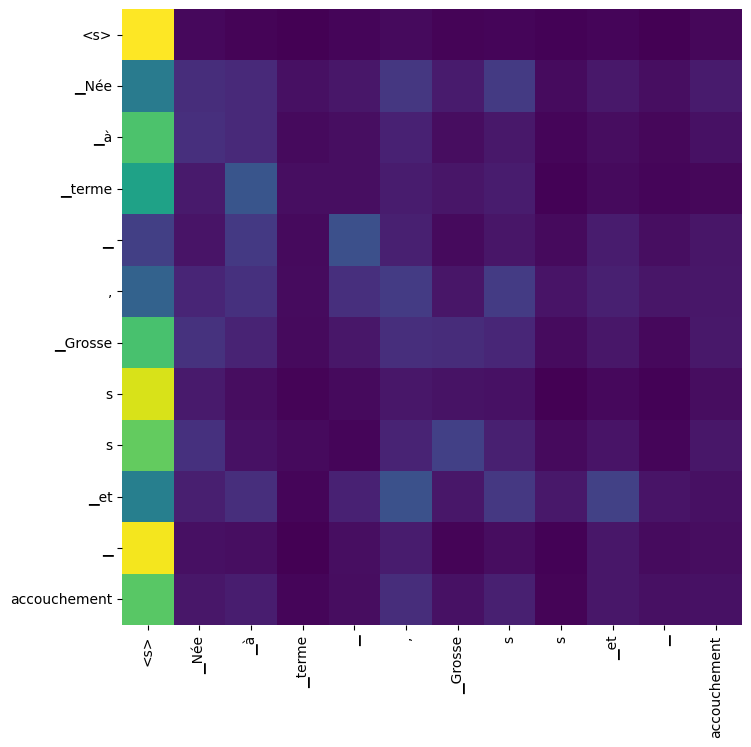

In [104]:
plt.figure(figsize=(8, 8))
sns.heatmap(
        attn_output_weights_visual,
        annot = False, 
        cbar=False,
        #fmt="d",
        xticklabels=token_names,
        yticklabels=token_names,
        cmap="viridis"
)    